In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.layers import Lambda

In [0]:
! unzip ./gdrive/My\ Drive/data.zip

In [0]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

person_train_valid = np.load("person_train_valid.npy")
person_test = np.load("person_test.npy")


In [0]:
X_train_valid = X_train_valid[:, :-3, :]
X_test = X_test[:, :-3, :]

X_train_valid = np.expand_dims(X_train_valid, 3)
X_test = np.expand_dims(X_test, 3)

person_train_valid = np.squeeze(person_train_valid)
person_test = np.squeeze(person_test)

y_train_valid -= 769
y_test -= 769


In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))

print ('Test data shape: {}'.format(X_test.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000, 1)
Test target shape: (443,)
Person test shape: (443,)


In [0]:
def create_model(n_filters=64, n_neurons=256, drops=[0.25,0.25,0.25], lr=1e-4, subject=False):
    
    # drops[0]: conv drop
    # drops[1]: GRU drop
    # drops[2]: GRU recurrent drop
    
    
    inputs = layers.Input(X_train_valid[0].shape)
    
    # conv
    x = layers.Conv2D(n_filters, (1,5), (1,5), 'valid')(inputs)
    #x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, (22, 1), (1,1), 'valid')(x)
    x = layers.ELU()(x)
    #x = layers.ReLU()(x)
    #x = layers.MaxPool2D((1,4), (1,1))(x)
    x = layers.AveragePooling2D((1,2), (1,2))(x)
    
    x = layers.Dropout(drops[0])(x)
    
    # reshape
    #x = layers.Permute((3,2,1))(x)
    x = layers.Permute((2,3,1))(x)
    
    def remove_axis(x):
        return backend.squeeze(x, 3)
    
    x = Lambda(remove_axis)(x)
      
    # LSTM
    x = layers.Bidirectional(layers.LSTM(n_neurons, dropout=drops[1], recurrent_dropout=drops[2]))(x)
    
    if subject:
        predictions = layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    else:
        predictions = layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
    #model.summary()
    
    # compile
    model.compile(optimizer=tf.train.AdamOptimizer(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
model_sig = create_model(n_filters=32, n_neurons=256, drops=[0.05, 0.05, 0.05])

history_sig = model_sig.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=200, batch_size=512, verbose=1)

#model.evaluate(X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2115 samples, validate on 443 samples
Epoch 1/200
2115/2115 [==============================] - 7s 3ms/sample - loss: 1.4867 - acc: 0.2629 - val_loss: 1.4619 - val_acc: 0.2731
Epoch 2/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4648 - acc: 0.2761 - val_loss: 1.4672 - val_acc: 0.2528
Epoch 3/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4595 - acc: 0.2894 - val_loss: 1.4540 - val_acc: 0.2912
Epoch 4/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4489 - acc: 0.3007 - val_loss: 1.4439 - val_acc: 0.3093
Epoch 5/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4443 - acc: 0.3187 - val_loss: 1.4401 - val_acc: 0.3093
Epoch 6/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.

In [10]:
model_subject = create_model(n_filters=32, n_neurons=256, drops=[0.05, 0.05, 0.05], subject=True)

history_subject = model_subject.fit(X_train_valid, person_train_valid, validation_data=(X_test, person_test), epochs=200, batch_size=512, verbose=1)


Train on 2115 samples, validate on 443 samples
Epoch 1/200
2115/2115 [==============================] - 6s 3ms/sample - loss: 2.3840 - acc: 0.1182 - val_loss: 2.3570 - val_acc: 0.1287
Epoch 2/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3415 - acc: 0.1622 - val_loss: 2.3238 - val_acc: 0.1738
Epoch 3/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3078 - acc: 0.1948 - val_loss: 2.2937 - val_acc: 0.2054
Epoch 4/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.2751 - acc: 0.2364 - val_loss: 2.2636 - val_acc: 0.2212
Epoch 5/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.2445 - acc: 0.2563 - val_loss: 2.2302 - val_acc: 0.2415
Epoch 6/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.2074 - acc: 0.2775 - val_loss: 2.1926 - val_acc: 0.2619
Epoch 7/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.1742 - acc: 0.2988 - val_loss: 2.1496 - val_acc: 0

In [0]:
def plot_train(history):
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history['loss'], label='train_loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoches')
    ax1.legend()
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history['acc'], label='train_acc')
    ax2.plot(history['val_acc'], label='val_acc')
    ax2.set_ylabel('acc')
    ax2.set_xlabel('epoches')
    ax2.legend()
    

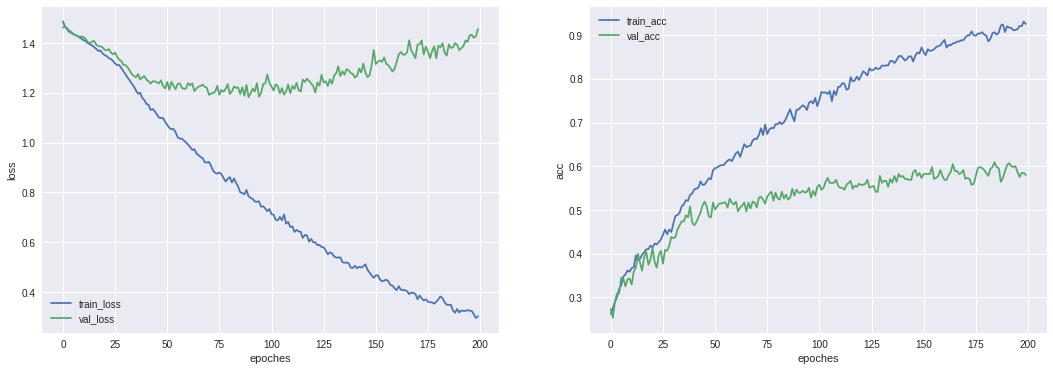

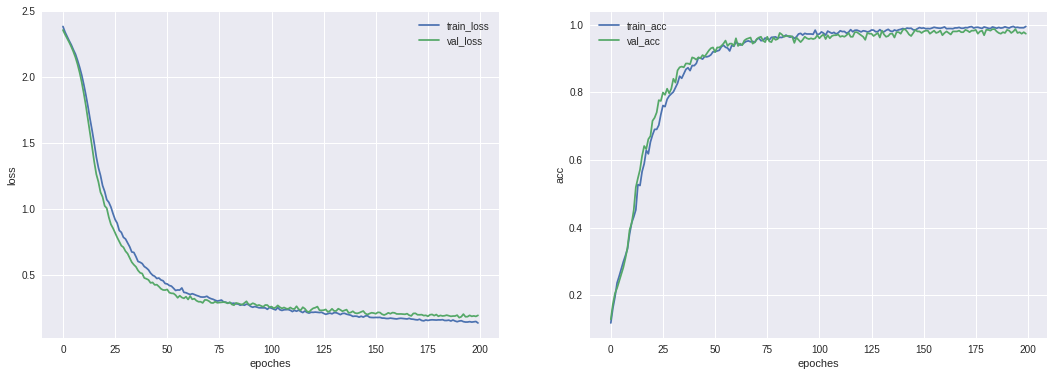

In [12]:
plot_train(history_sig.history)
plot_train(history_subject.history)


In [0]:
def accuracy_over_time(model, X_test, y_test, period=100):
    
    X = X_test.copy()
    
    n = 1000 // period
    acc = [0]*n
    
    for i in range(n):
        if i != 0:
            X[:,:,-period*i:] = 0
            
        acc[i] = np.sum(np.argmax(model.predict(X), axis=1) == y_test) / len(y_test)
  
    acc = acc[::-1]
    max_acc = max(acc)
    max_acc_idx = acc.index(max_acc)
    best_seq_len = max_acc_idx*period
    print(f'max acc: {max_acc:.3f} with sequence length: {best_seq_len}')
    
    
    x = list(range(0, 1000, period))
  
    plt.plot(x, acc)
    plt.axvline(best_seq_len, color='c', linestyle='--')
    plt.axhline(max_acc, color='c', linestyle='--')
    plt.xlabel('sequence length')
    plt.ylabel('acc')
    
    

max acc: 0.596 with sequence length: 890


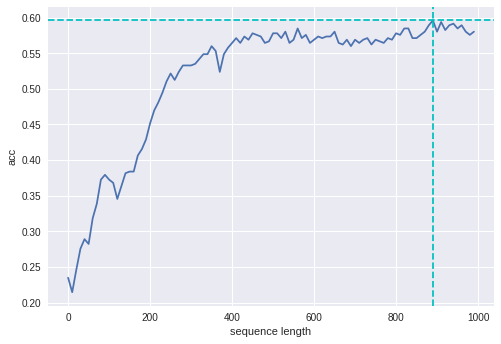

In [14]:
accuracy_over_time(model_sig, X_test, y_test, 10)

max acc: 0.975 with sequence length: 920


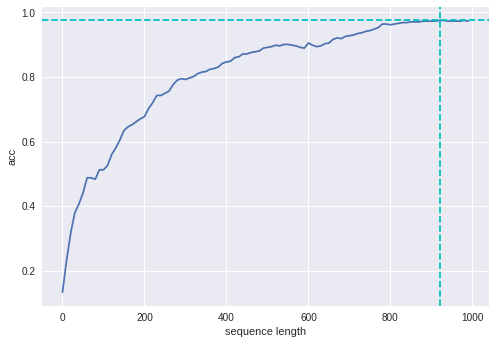

In [15]:
accuracy_over_time(model_subject, X_test, person_test, 10)

In [16]:
from sklearn.metrics import f1_score

y_pred_sig = np.argmax(model_sig.predict(X_test), 1)
print('F1 of signal classification: ')
print(f1_score(y_test, y_pred_sig, average=None))

y_pred_sub = np.argmax(model_subject.predict(X_test), 1)
print('F1 of signal classification: ')
print(f1_score(person_test, y_pred_sub, average=None))

F1 of signal classification: 
[0.5645933  0.5859375  0.51546392 0.64317181]
F1 of signal classification: 
[0.98039216 0.94230769 0.95833333 0.98039216 0.95555556 0.98969072
 1.         0.96078431 0.98924731]
